In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

In [2]:
import numpy as np
import random

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pylab as plt

import glob
from glob import glob
import nibabel as nb

In [3]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [4]:
device='cpu'

In [4]:
from dataclasses import dataclass

@dataclass
class Parameters:
    bs : int
    n_channels : int
    ngf : int
    ndf : int
    size : int
    gen_n_down : int
    gen_n_blocks : int
    dis_n_down : int
    lr : float
    beta1 : float
    beta1_disc : float

In [5]:
def init_dataloaders(p):
    workers = 2
    image_size = (64,64)
    dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\same_patch_dataset\train'
    datasets_train = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0, 0, 0), (1, 1, 1)),
                                  ]))

    from torch.utils import data
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['B']]
    mri_subset = data.Subset(datasets_train, idx)
    dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=p.bs,
                                             shuffle=True, num_workers=workers)
    idx = [i for i in range(len(datasets_train)) if datasets_train.imgs[i][1] != datasets_train.class_to_idx['A']]
    sos_subset = data.Subset(datasets_train, idx)

    dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=p.bs,
                                             shuffle=True, num_workers=workers)
    return dataloader_mri, dataloader_sos

In [6]:
from ResnetGenerator import ResnetGenerator
from NLayerDiscriminator import NLayerDiscriminator

def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

criterion_Im = torch.nn.L1Loss() 

In [7]:
def init_models(p):
    G_A2B = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, n_downsampling=p.gen_n_down, padding_type='reflect')
    G_B2A = ResnetGenerator(input_nc=p.n_channels,output_nc=p.n_channels,ngf=p.ngf,norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=p.gen_n_blocks, padding_type='reflect')
    D_A = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)
    D_B = NLayerDiscriminator(input_nc=p.n_channels,ndf=p.ndf,n_layers=p.dis_n_down, norm_layer=nn.BatchNorm2d)

    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))

    return G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B

In [8]:
def save_models(G_A2B, G_B2A, D_A, D_B, name):

  torch.save(G_A2B, name+"_G_A2B.pt")
  torch.save(G_B2A,  name+"_G_B2A.pt")
  torch.save(D_A,  name+"_D_A.pt")
  torch.save(D_B, name+"_D_B.pt")

def load_models( name):
  G_A2B=torch.load(name+'_G_A2B.pt', map_location=torch.device('cpu'))
  G_B2A=torch.load(name+"_G_B2A.pt",map_location=torch.device('cpu'))
  D_A=torch.load(name+"_D_A.pt", map_location=torch.device('cpu'))
  D_B=torch.load(name+"_D_B.pt", map_location=torch.device('cpu'))
  return G_A2B, G_B2A, D_A, D_B

In [9]:
def sweep(p,name):

    dataloader_mri, dataloader_sos = init_dataloaders(p)

    G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B = init_models(p)
    G_A2B.to(device)
    G_B2A.to(device)
    D_A.to(device)
    D_B.to(device)

    G_losses, D_losses = training(5, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name)
#     print("Generator loss at the beginning of each epoch ",G_losses[::1653])
#     print("Generator minimal loss ",min(G_losses), "iteration ",G_losses.index(min(G_losses)))

In [13]:
def sweep(p,name):

    dataloader_mri, dataloader_sos = init_dataloaders(p)

    G_A2B, G_B2A, D_A, D_B= load_models("4"+name)
    G_A2B.to(device)
    G_B2A.to(device)
    D_A.to(device)
    D_B.to(device)
    optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
    optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

    optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
    optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))

    G_losses, D_losses = training(3, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name)
#     print("Generator loss at the beginning of each epoch ",G_losses[::1653])
#     print("Generator minimal loss ",min(G_losses), "iteration ",G_losses.index(min(G_losses)))

In [10]:
def training(epochs, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name):
    
    iters=0
    G_losses = []
    D_losses = []
    print('Starting training loop')
    # For each epoch
    for epoch in range(epochs):

        # For each batch in the dataloader
        for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
            temp_D_losses = 0
            # print(b)
            # Set model input
            a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
            b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
            
            # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
            # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

            # Generated images
            # print("a_real shape: "+str(a_real.shape))
            b_fake = G_A2B(a_real)
            # print("fake image generated")
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)

            # CALCULATE DISCRIMINATORS LOSSES
            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_A

            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                temp_D_losses += Disc_loss_A

            # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
            # D_A_losses.append(Disc_loss_A.item())
            
            Disc_loss_A.backward()
            optimizer_D_A.step()

            
            # Discriminator B

            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_B
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                temp_D_losses += Disc_loss_B

            Disc_loss_B.backward()
            optimizer_D_B.step()   
            
            # different
            # Generator
            

            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()


            # CALCULATE GENERATORS LOSSES
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        

            wandb.log({
                "total_g": Loss_G,
                "total_d": temp_D_losses
            })

            # Backward propagation
            Loss_G.backward()
            
            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()


            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == 5 and b_fake.shape[0]==1):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del a_real, b_real, a_fake, b_fake

        print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                            % (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        save_models(G_A2B,G_B2A,D_A,D_B,str(epoch)+name)
        iters = 0
    
    
    return G_losses, D_losses

In [14]:
def training(epochs, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name):
    
    iters=0
    G_losses = []
    D_losses = []
    print('Starting training loop')
    # For each epoch
    for epoch in range(epochs):

        # For each batch in the dataloader
        for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
            temp_D_losses = 0
            # print(b)
            # Set model input
            a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
            b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
            
            # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
            # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

            # Generated images
            # print("a_real shape: "+str(a_real.shape))
            b_fake = G_A2B(a_real)
            # print("fake image generated")
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)

            # CALCULATE DISCRIMINATORS LOSSES
            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_A

            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                temp_D_losses += Disc_loss_A

            # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
            # D_A_losses.append(Disc_loss_A.item())
            
            Disc_loss_A.backward()
            optimizer_D_A.step()

            
            # Discriminator B

            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_B
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                temp_D_losses += Disc_loss_B

            Disc_loss_B.backward()
            optimizer_D_B.step()   
            
            # different
            # Generator
            

            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()


            # CALCULATE GENERATORS LOSSES
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        

            wandb.log({
                "total_g": Loss_G,
                "total_d": temp_D_losses
            })

            # Backward propagation
            Loss_G.backward()
            
            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()


            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == 5 and b_fake.shape[0]==1):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del a_real, b_real, a_fake, b_fake

        print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                            % (epoch+6, epochs+5, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        save_models(G_A2B,G_B2A,D_A,D_B,str(epoch+5)+name)
        iters = 0
    
    
    return G_losses, D_losses

In [14]:
def training(epochs, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name):
    fin = open(name+"_gen.txt","w")
    fdisc = open(name+"_disc.txt","w")
    iters=0
    G_losses = []
    D_losses = []
    G_loss_epochs = []
    print('Starting training loop')
    # For each epoch
    for epoch in range(epochs):

        # For each batch in the dataloader
        for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
            temp_D_losses = 0
            # print(b)
            # Set model input
            a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
            b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
            
            # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
            # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

            # Generated images
            # print("a_real shape: "+str(a_real.shape))
            b_fake = G_A2B(a_real)
            # print("fake image generated")
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)

            # CALCULATE DISCRIMINATORS LOSSES
            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_A

            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                temp_D_losses += Disc_loss_A

            # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
            # D_A_losses.append(Disc_loss_A.item())
            
            Disc_loss_A.backward()
            optimizer_D_A.step()

            
            # Discriminator B

            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_B
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                temp_D_losses += Disc_loss_B

            Disc_loss_B.backward()
            optimizer_D_B.step()   
            
            D_losses.append(temp_D_losses) # different
            # Generator
            

            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()


            # CALCULATE GENERATORS LOSSES
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
            G_losses.append(Loss_G)

            wandb.log({
                "total_g": Loss_G,
                "total_d": temp_D_losses
            })

            # Backward propagation
            Loss_G.backward()
            
            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()


            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == 5 and b_fake.shape[0]==1):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del a_real, b_real, a_fake, b_fake


            if iters % 50 == 0:
            
                print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                            % (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                                Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
                # print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                #             % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B, Disc_loss_A.item(), Disc_loss_B.item()))
        save_models(G_A2B,G_B2A,D_A,D_B,str(epoch)+name)
        iters = 0
        G_loss_epochs.append(Loss_G)
        D_loss_epochs.append(temp_D_losses)
    fin.write(','.join(str(num) for num in G_loss_epochs))
    fin.write("\n")
    fdisc.write(','.join(str(num) for num in D_loss_epochs))
    fin.write("\n")
    return G_losses, D_losses

In [10]:
def training(epochs, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name):
    
    iters=0
    G_losses = []
    D_losses = []
    
    print('Starting training loop')
    # For each epoch
    for epoch in range(epochs):

        # For each batch in the dataloader
        for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
            temp_D_losses = 0
            # print(b)
            # Set model input
            a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
            b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)
            
            # tensor_ones=torch.ones([a_real.shape[0],1,14,14]).to(device)
            # tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).to(device)

            # Generated images
            # print("a_real shape: "+str(a_real.shape))
            b_fake = G_A2B(a_real)
            # print("fake image generated")
            a_rec = G_B2A(b_fake)
            a_fake = G_B2A(b_real)
            b_rec = G_A2B(a_fake)

            # CALCULATE DISCRIMINATORS LOSSES
            # Discriminator A
            optimizer_D_A.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_a_fake.shape[0]-1)
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_A

            else:
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                temp_D_losses += Disc_loss_A

            # Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
            # D_A_losses.append(Disc_loss_A.item())
            
            Disc_loss_A.backward()
            optimizer_D_A.step()

            
            # Discriminator B

            optimizer_D_B.zero_grad()
            if((iters > 0 or epoch > 0) and iters % 3 == 0):
                rand_int = random.randint(1, old_b_fake.shape[0]-1)
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-1:rand_int].detach()))
                temp_D_losses += Disc_loss_B
            else:
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                temp_D_losses += Disc_loss_B

            Disc_loss_B.backward()
            optimizer_D_B.step()   
            
            D_losses.append(temp_D_losses) # different
            # Generator
            

            optimizer_G_A2B.zero_grad()
            optimizer_G_B2A.zero_grad()


            # CALCULATE GENERATORS LOSSES
            Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
            Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

            # Cycle Consistency    both use the two generators
            Cycle_loss_A = criterion_Im(a_rec, a_real)*5
            Cycle_loss_B = criterion_Im(b_rec, b_real)*5

            # Identity loss
            Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
            Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

            # generator losses
            Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
            G_losses.append(Loss_G)

            wandb.log({
                "total_g": Loss_G,
                "total_d": temp_D_losses
            })

            # Backward propagation
            Loss_G.backward()
            
            # Optimisation step
            optimizer_G_A2B.step()
            optimizer_G_B2A.step()


            if(iters == 0 and epoch == 0):
                old_b_fake = b_fake.clone()
                old_a_fake = a_fake.clone()
            elif (old_b_fake.shape[0] == 5 and b_fake.shape[0]==1):
                rand_int = random.randint(5, 24)
                old_b_fake[rand_int-5:rand_int] = b_fake.clone()
                old_a_fake[rand_int-5:rand_int] = a_fake.clone()
            elif(old_b_fake.shape[0]< 25):
                old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
                old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

            iters += 1
            del a_real, b_real, a_fake, b_fake


            if iters % 50 == 0:
            
                print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                            % (epoch+1, epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                                Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
                # print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                #             % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B, Disc_loss_A.item(), Disc_loss_B.item()))
        save_models(G_A2B,G_B2A,D_A,D_B,"test_"+name+str(epoch))
        iters = 0            
    return G_losses, D_losses

In [16]:
import wandb
!wandb login 2511293b7c38a80081cadf8f2737b2f6fa992e70
#wandb.init(project="mri2sos", entity="powerr")
#name = ["resnet0","resnet1","resnet2","resnet3","resnet4","resnet5","resnet6","resnet7","resnet8","resnet9","disc1","disc3","disc0","gener0","gener1","gener3","gener4"]
#name = ["resnet83","resnet93"]
name = ["resnet90","resnet50","resnet60","resnet70"]
#name = ["a1_2","a2_2","a3_2","a4_2","a5_2","a6_2","a7_2","a8_2","a9_2"]
#name = ["a7","a8","a9"]
# name = ["lr0001","gendown3","bs4"]
#name = ["bs4lr0001b06","bs4lr0001b09","bs4lr0001b06dis4","bs4lr0002b09"]
ps = []
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=0, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=1, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=2, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=3, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=4, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))

#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=8, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=5, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=7, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=1, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=3, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=0, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=0, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))

#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=3, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=4, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))

# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0001, beta1=0.6,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0001, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0002, beta1=0.6,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0002, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=0, dis_n_down=4, lr=0.0002, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=6, dis_n_down=4, lr=0.0002, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=18, dis_n_down=4, lr=0.0002, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=3, gen_n_blocks=9, dis_n_down=4, lr=0.0002, beta1=0.9,beta1_disc=0.9))

# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.6,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0001, beta1=0.6,beta1_disc=0.9))
# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=3, gen_n_blocks=9, dis_n_down=2, lr=0.0001, beta1=0.9,beta1_disc=0.6))

# ps.append(Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=4, lr=0.0001, beta1=0.9,beta1_disc=0.9))
#ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=1, gen_n_blocks=6, dis_n_down=2, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=128, ndf=64, size=64, gen_n_down=1, gen_n_blocks=8, dis_n_down=1, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=9, dis_n_down=2, lr=0.001, beta1=0.9))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=3, gen_n_blocks=6, dis_n_down=2, lr=0.002, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=4, gen_n_blocks=6, dis_n_down=4, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=64, ndf=16, size=64, gen_n_down=4, gen_n_blocks=1, dis_n_down=4, lr=0.001, beta1=0.6))
# ps.append(Parameters(bs=1, n_channels=1, ngf=32, ndf=64, size=64, gen_n_down=1, gen_n_blocks=6, dis_n_down=2, lr=0.001, beta1=0.6))

#for j in range(5):
for i in range(len(ps)):
        p = ps[i]
        wandb.init(project="mri2sos", entity="powerr", name=name[i],config = {
             "ngf" : p.ngf,
             "ndf" : p.ndf,
             "gen_n_down" : p.gen_n_down,
             "gen_n_blocks" : p.gen_n_blocks,
             "dis_n_down" : p.dis_n_down,
             "lr" : p.lr,
             "beta1" : p.beta1,
             "beta1_disc" : p.beta1_disc

             })


        sweep(p,name[i])
   

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Xiaowei/.netrc


Starting training loop
[6/8]	FDL_A2B: 0.2774	FDL_B2A: 0.2513	CL_A: 0.2146	CL_B: 0.1090	ID_B2A: 0.2090	ID_A2B: 0.1230	Loss_D_A: 0.4538	Loss_D_A: 0.4671
[7/8]	FDL_A2B: 0.2258	FDL_B2A: 0.2388	CL_A: 0.1816	CL_B: 0.0998	ID_B2A: 0.1207	ID_A2B: 0.0984	Loss_D_A: 0.4801	Loss_D_A: 0.4862
[8/8]	FDL_A2B: 0.3186	FDL_B2A: 0.1255	CL_A: 0.2309	CL_B: 0.0826	ID_B2A: 0.1580	ID_A2B: 0.0909	Loss_D_A: 0.6144	Loss_D_A: 0.3399


total_d,▄▇▄███▂█▆▄▂█▇▃▅▆▂█▇▂▃▇▆▁▇▆█▅▆▃▄▅▇▂▇▇▇▂▆▅
total_g,▇▆▄▃▃▂▃▆█▁▅▂▃▃▆▆▅▂▂█▁▃▂▄▄▄█▄▃▆▄▂▂▂▁▂▁▃▂▃
total_d,0.95428
total_g,1.00644


Starting training loop
[6/8]	FDL_A2B: 0.1948	FDL_B2A: 0.2119	CL_A: 0.2414	CL_B: 0.1016	ID_B2A: 0.3605	ID_A2B: 0.1335	Loss_D_A: 0.5312	Loss_D_A: 0.4420
[7/8]	FDL_A2B: 0.2432	FDL_B2A: 0.1587	CL_A: 0.2132	CL_B: 0.1370	ID_B2A: 0.1832	ID_A2B: 0.1920	Loss_D_A: 0.4944	Loss_D_A: 0.6805
[8/8]	FDL_A2B: 0.3110	FDL_B2A: 0.2571	CL_A: 0.2118	CL_B: 0.0863	ID_B2A: 0.1787	ID_A2B: 0.0988	Loss_D_A: 0.4914	Loss_D_A: 0.4703


total_d,▆▇▄▇▆▆▅▇▇▃▃▅▆▂▇▇▂▆▆▂▂▇▆▂▆▇█▇▇▃▁▇▇▂▇▅▆▃▆▇
total_g,▄▄▆▃█▅▅▃▃▃▄▄▄▂▅▄▅▆▄▃▃▃▅▂▂▂▂▃▃▄▄▂▄▁▂▅▃▄▃▃
total_d,0.9617
total_g,1.14368


Starting training loop
[6/8]	FDL_A2B: 0.1298	FDL_B2A: 0.2277	CL_A: 0.2474	CL_B: 0.1052	ID_B2A: 0.1793	ID_A2B: 0.1299	Loss_D_A: 0.5547	Loss_D_A: 0.5427
[7/8]	FDL_A2B: 0.2253	FDL_B2A: 0.2716	CL_A: 0.2793	CL_B: 0.1036	ID_B2A: 0.2950	ID_A2B: 0.1362	Loss_D_A: 0.4577	Loss_D_A: 0.4517
[8/8]	FDL_A2B: 0.2115	FDL_B2A: 0.2931	CL_A: 0.1923	CL_B: 0.1118	ID_B2A: 0.1756	ID_A2B: 0.1297	Loss_D_A: 0.3947	Loss_D_A: 0.5928


total_d,▆▇▄█▆▇▂▆▇▂▂▅▇▂▇▇▃▇▆▂▁▇▄▃▆▆▆▇▇▁▁▅▆▁▆▅▆▁▇▆
total_g,██▆▃▇▄▅▄▅▆▃▅▃▃▅▁▃▆▄▂▂▃▅▃▃▃▂▄▂▄▂▄▃▅▂▅▃▄▂▃
total_d,0.98745
total_g,1.11392


Starting training loop
[6/8]	FDL_A2B: 0.2207	FDL_B2A: 0.3101	CL_A: 0.1997	CL_B: 0.1143	ID_B2A: 0.1674	ID_A2B: 0.1102	Loss_D_A: 0.4702	Loss_D_A: 0.3971
[7/8]	FDL_A2B: 0.3867	FDL_B2A: 0.1357	CL_A: 0.1628	CL_B: 0.1378	ID_B2A: 0.1184	ID_A2B: 0.1557	Loss_D_A: 0.5871	Loss_D_A: 0.4094
[8/8]	FDL_A2B: 0.3583	FDL_B2A: 0.1684	CL_A: 0.1810	CL_B: 0.0788	ID_B2A: 0.1375	ID_A2B: 0.0916	Loss_D_A: 0.5129	Loss_D_A: 0.5126


In [52]:
name = "5res0"
p = Parameters(bs=4, n_channels=1, ngf=64, ndf=64, size=64, gen_n_down=2, gen_n_blocks=0, dis_n_down=2, lr=0.0002, beta1=0.9,beta1_disc=0.9)
wandb.init(project="mri2sos", entity="powerr",name=name,config = {
         "ngf" : p.ngf,
         "ndf" : p.ndf,
         "gen_n_down" : p.gen_n_down,
         "gen_n_blocks" : p.gen_n_blocks,
         "dis_n_down" : p.dis_n_down,
         "lr" : p.lr,
         "beta1" : p.beta1,
         "beta1_disc" : p.beta1_disc
        
         })
    
sweep(p,name)

total_d,▄▃▆▃▃▂▃▄▂▅▅▂▁▄▂▂▇▅▄▁▂▃▅▅▃▃▄▂▂▃▇▆▅▆▃▂▃█▃▇
total_g,▆▆▄▆▆█▅▅█▄▄▃▄▆▆▄▄▅▃▄▃▅▁▂▆▂▅▃▂▆▂▂▃▃▄▃▄▂▄▂
total_d,1.12719
total_g,2.03593


Starting training loop
[1/5]	FDL_A2B: 0.2633	FDL_B2A: 0.2118	CL_A: 0.3105	CL_B: 0.2901	ID_B2A: 0.5428	ID_A2B: 0.5094	Loss_D_A: 0.6140	Loss_D_A: 0.5006
[1/5]	FDL_A2B: 0.3229	FDL_B2A: 0.2510	CL_A: 0.2484	CL_B: 0.1674	ID_B2A: 0.4442	ID_A2B: 0.3174	Loss_D_A: 0.1742	Loss_D_A: 0.1792
[1/5]	FDL_A2B: 0.1625	FDL_B2A: 0.3132	CL_A: 0.2824	CL_B: 0.1952	ID_B2A: 0.4668	ID_A2B: 0.2771	Loss_D_A: 0.4442	Loss_D_A: 0.5533
[1/5]	FDL_A2B: 0.2958	FDL_B2A: 0.6694	CL_A: 0.2812	CL_B: 0.2106	ID_B2A: 0.4639	ID_A2B: 0.3854	Loss_D_A: 0.0904	Loss_D_A: 0.3965
[1/5]	FDL_A2B: 0.1857	FDL_B2A: 0.7567	CL_A: 0.2241	CL_B: 0.1702	ID_B2A: 0.3314	ID_A2B: 0.3222	Loss_D_A: 0.1384	Loss_D_A: 0.4520
[1/5]	FDL_A2B: 0.2323	FDL_B2A: 0.9933	CL_A: 0.2395	CL_B: 0.1527	ID_B2A: 0.3969	ID_A2B: 0.2660	Loss_D_A: 0.2344	Loss_D_A: 0.4274
[1/5]	FDL_A2B: 0.1921	FDL_B2A: 0.6094	CL_A: 0.2167	CL_B: 0.1544	ID_B2A: 0.3648	ID_A2B: 0.3136	Loss_D_A: 0.2976	Loss_D_A: 0.4910
[1/5]	FDL_A2B: 0.2670	FDL_B2A: 0.6736	CL_A: 0.1727	CL_B: 0.2186	ID_B2A: 0.2705	ID

In [39]:
path = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\same_patch_dataset\test'
dataset_mri = torch.load(path+'\mri_dataset.pt')
dataset_sos = torch.load(path+'\sos_dataset.pt')
print(len(dataset_mri))
test_mris = dataset_mri[:50][:,:,:,0]
test_soss = dataset_sos[:50][:,:,:,0]

546


res1


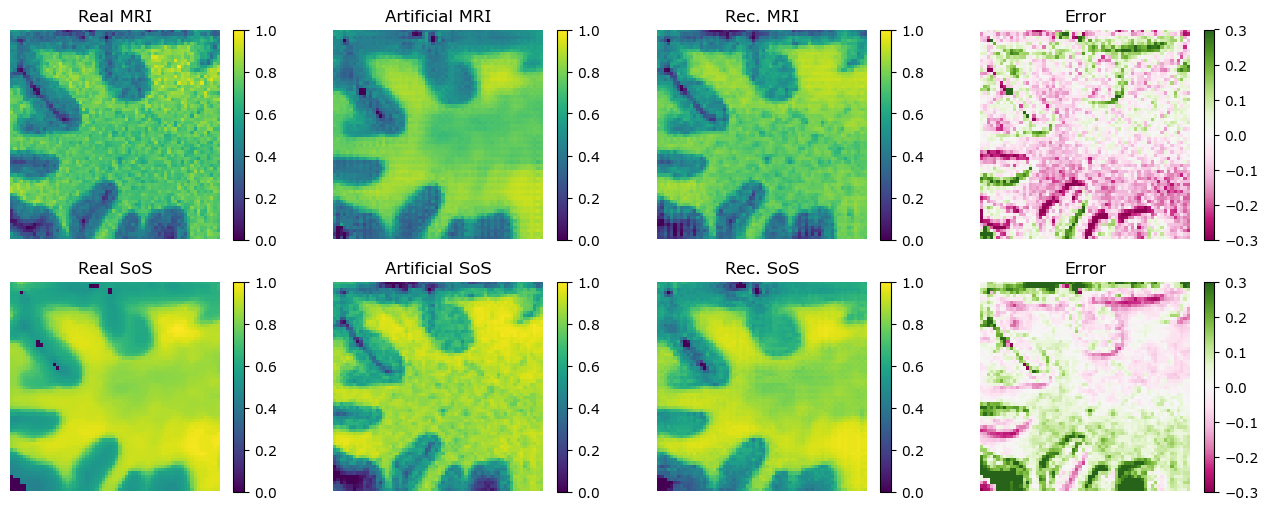

res2


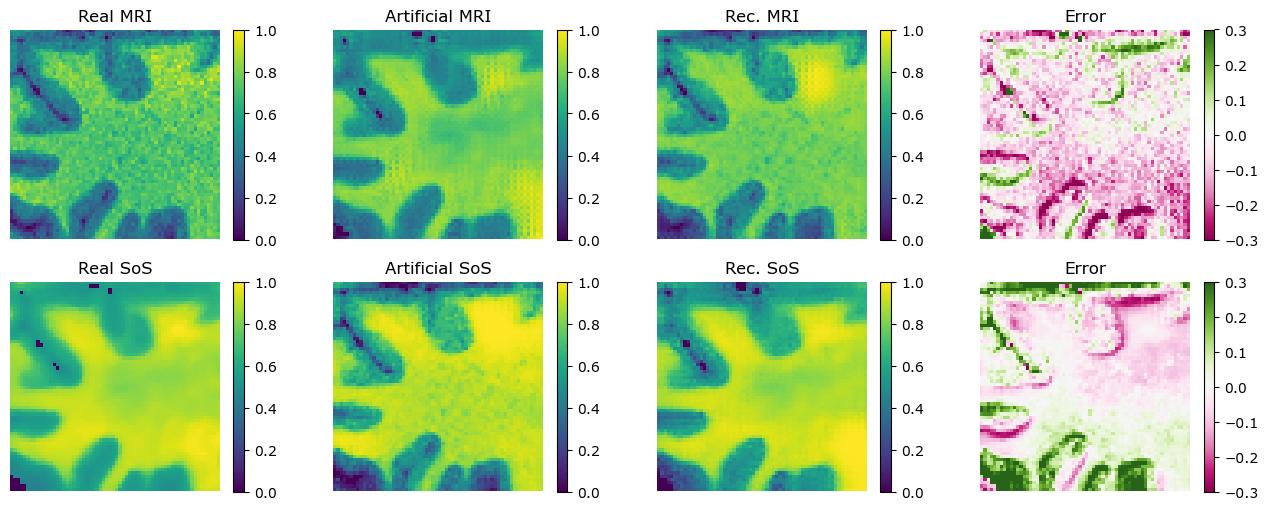

res3


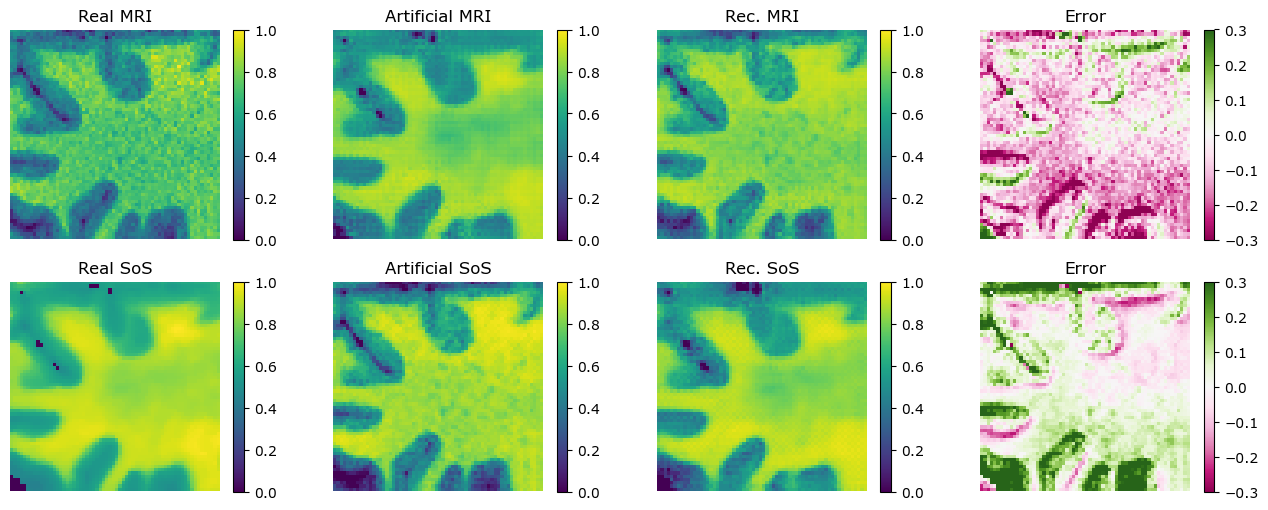

res4


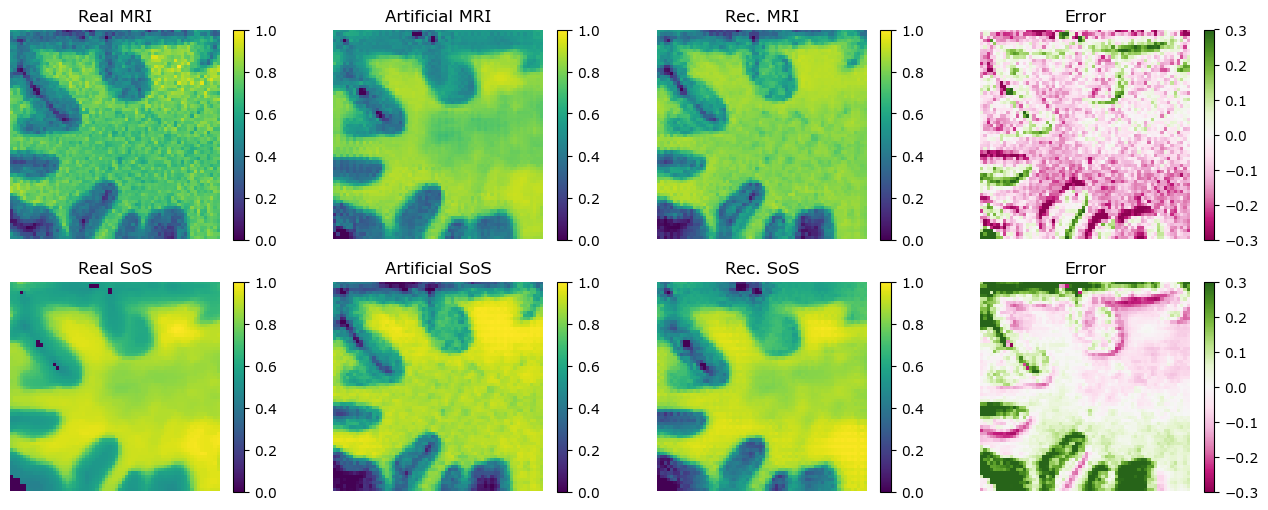

res5


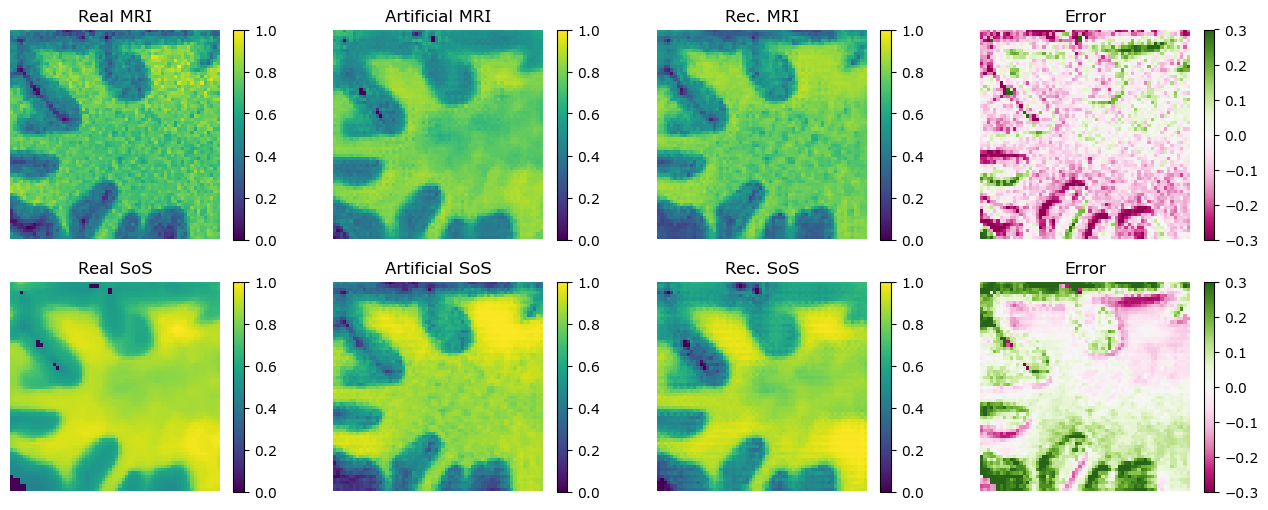

res6


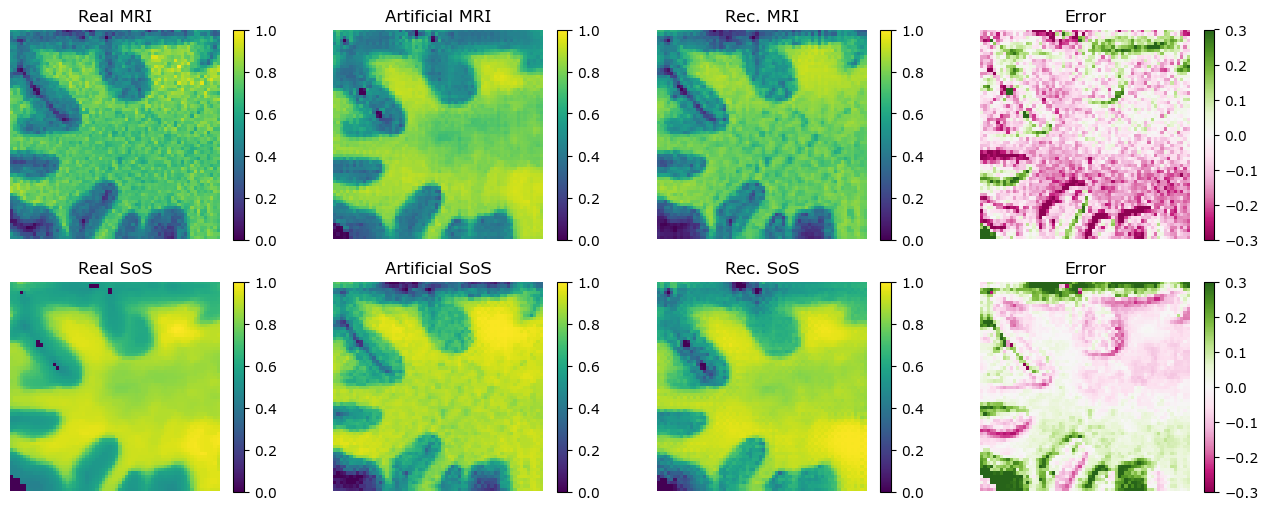

res7


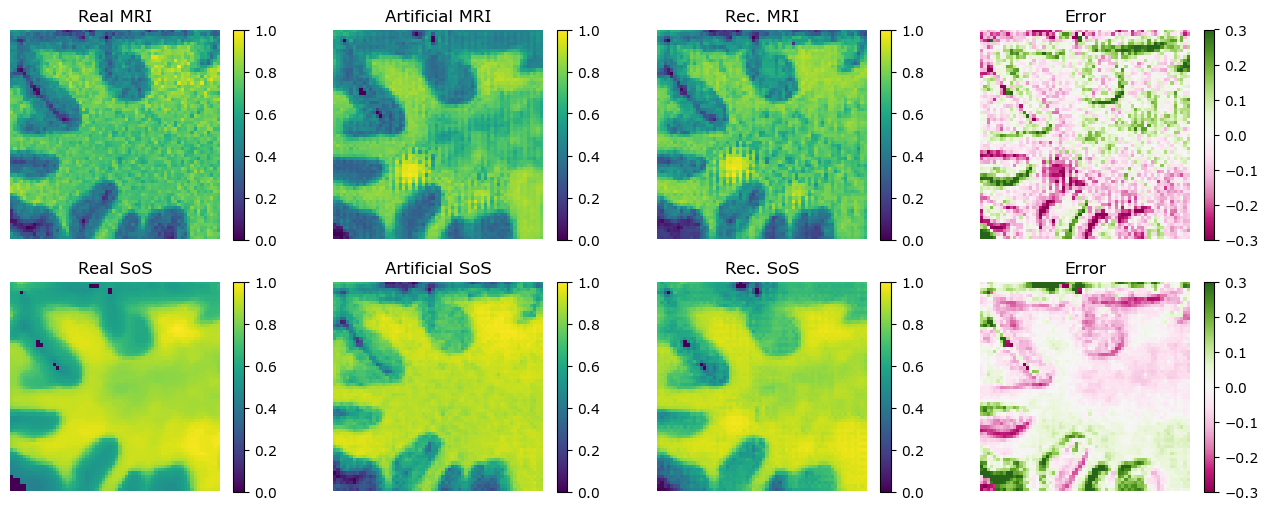

res8


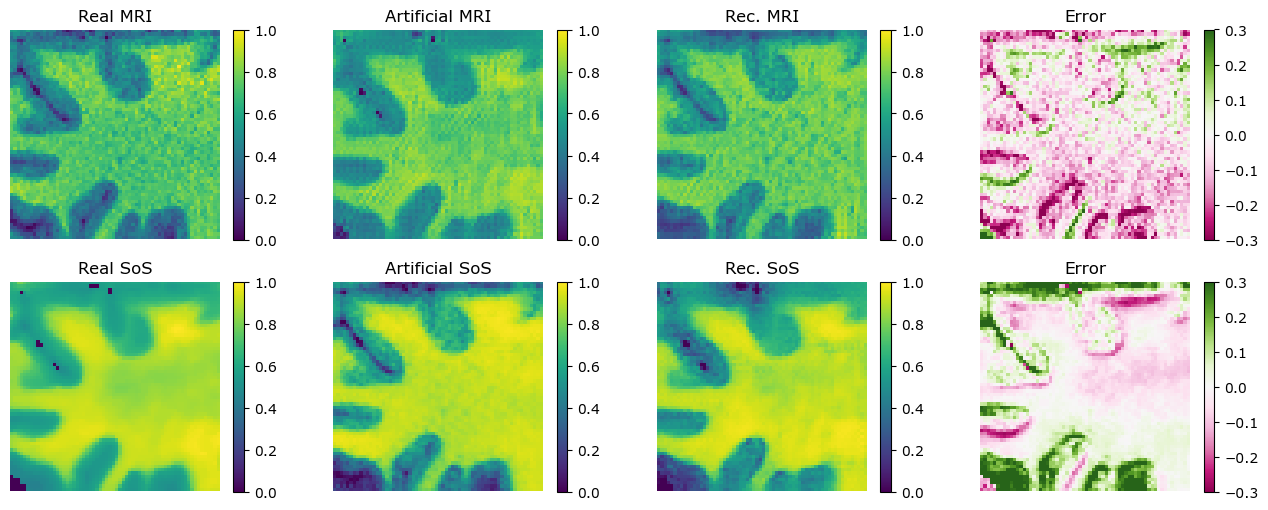

res9


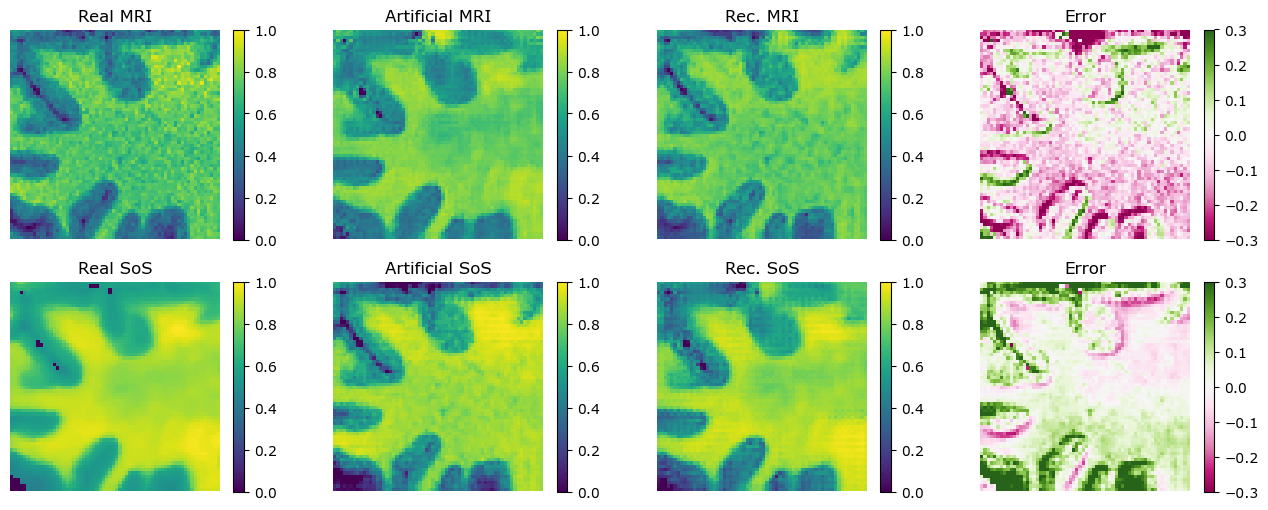

dis1


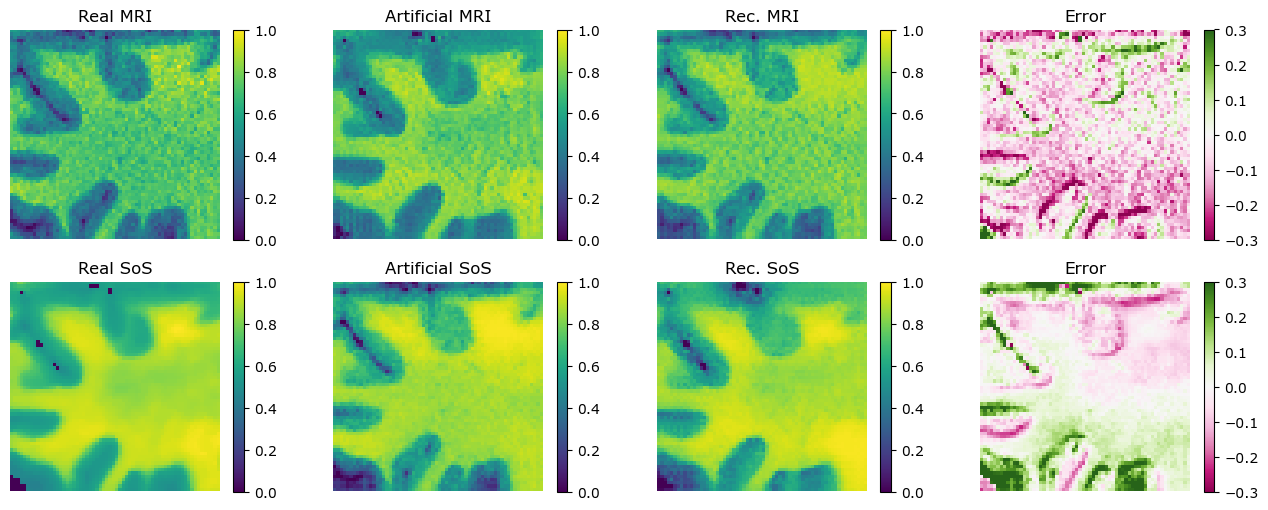

dis3


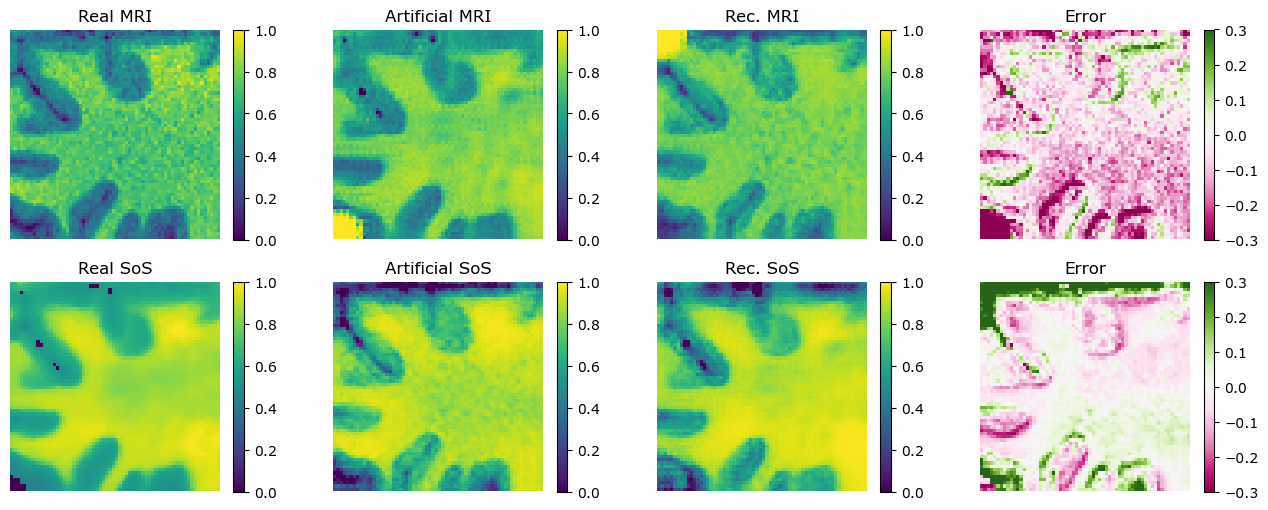

dis0


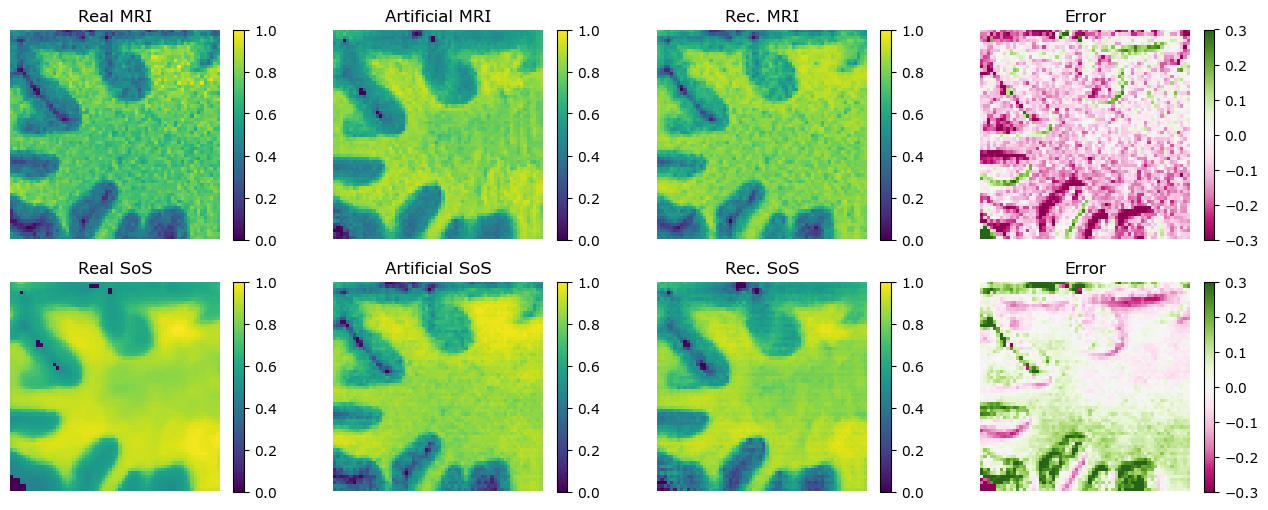

gen0


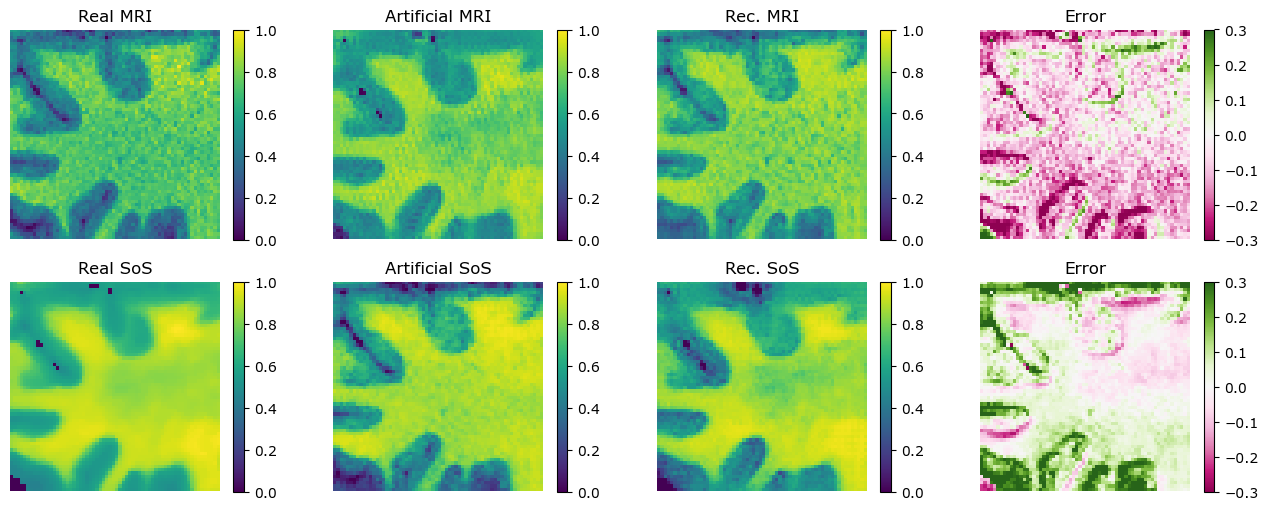

gen1


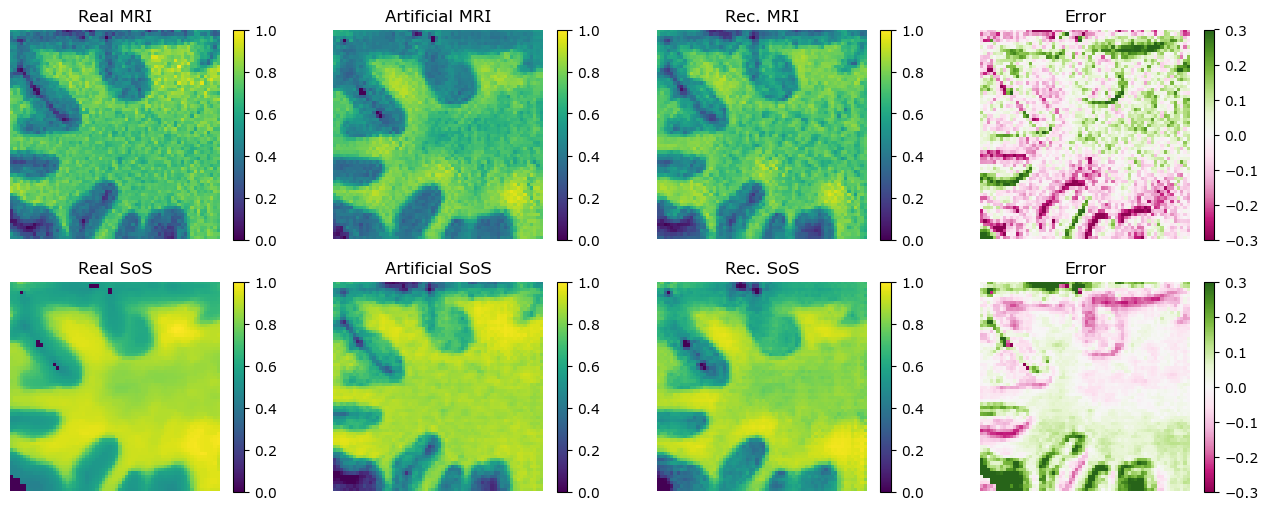

gen3


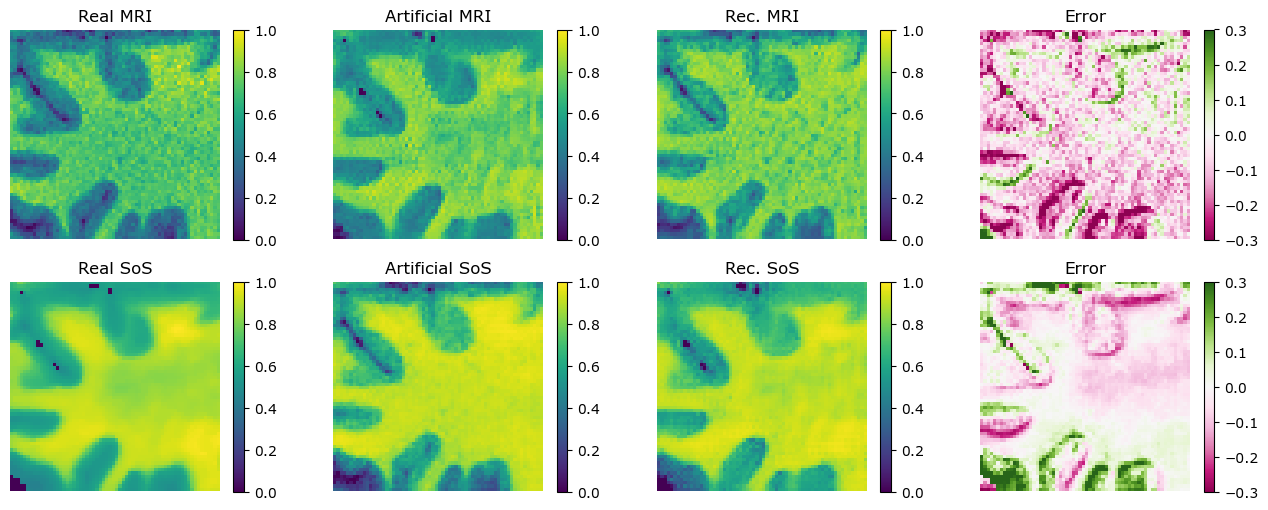

gen4


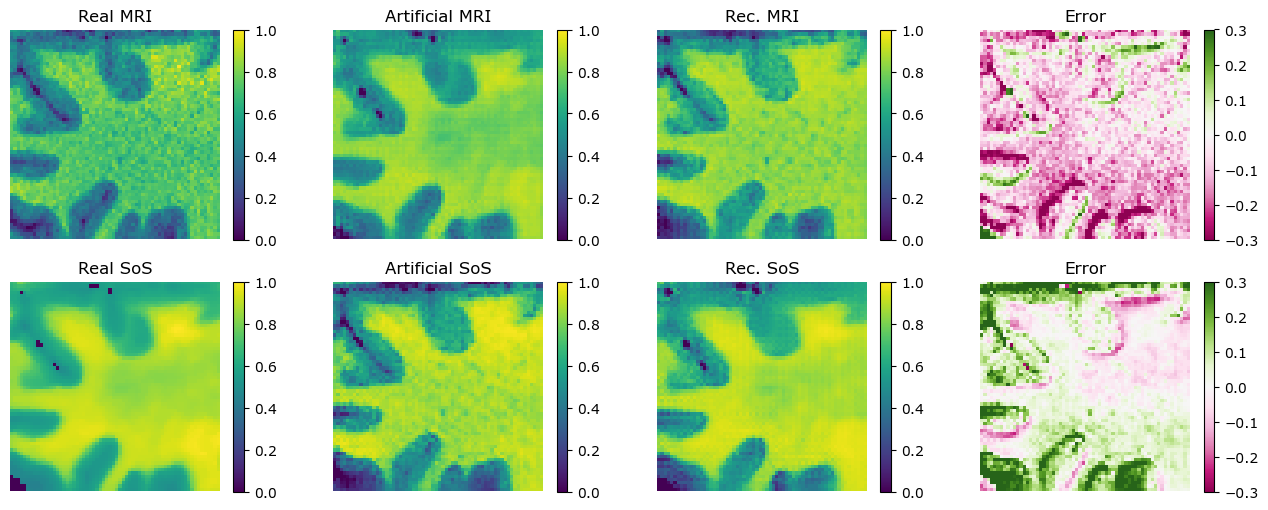

In [40]:
for s in range(len(ps)):
    test_fake_mris = []
    test_fake_soss = []
    test_rec_mris = []
    test_rec_soss = []
    G_A2B, G_B2A, D_A, D_B=load_models(name[s])
    G_A2B.to(device)
    G_B2A.to(device)
    D_A.to(device)
    D_B.to(device)
    for i in range(len(test_mris)):
        real_mri = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0)
        fake_sos = G_A2B(real_mri.to(device)).cpu().detach().numpy()
        rec_mri = G_B2A(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

        real_sos = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0)
        fake_mri = G_B2A(real_sos.to(device)).cpu().detach().numpy()
        rec_sos = G_A2B(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

        test_fake_mris.append(fake_mri)
        test_fake_soss.append(fake_sos)
        test_rec_mris.append(rec_mri)
        test_rec_soss.append(rec_sos)

        with torch.no_grad():
            real_mri.detach().cpu()
            real_sos.detach().cpu()
    n=3
    print(name[s])
    plt.subplots(2,4,figsize=(16,6));
    plt.subplot(2,4,1);plt.imshow(test_mris[n]); plt.title('Real MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,2);plt.imshow(test_fake_mris[n][0,0,:,:]); plt.title('Artificial MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,3);plt.imshow(test_rec_mris[n][0,0,:,:]); plt.title('Rec. MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,4);plt.imshow(test_mris[n]-test_fake_mris[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
    plt.subplot(2,4,5);plt.imshow(test_soss[n]); plt.title('Real SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,6);plt.imshow(test_fake_soss[n][0,0,:,:]); plt.title('Artificial SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,7);plt.imshow(test_rec_soss[n][0,0,:,:]); plt.title('Rec. SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
    plt.subplot(2,4,8);plt.imshow(test_soss[n]-test_fake_soss[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
    plt.show()



In [ ]:
test_fake_mris = []
test_fake_soss = []
test_rec_mris = []
test_rec_soss = []
G_A2B, G_B2A, D_A, D_B=load_models("bs4_train3")
G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)
for i in range(len(test_mris)):
        real_mri = torch.Tensor(test_mris[i]).unsqueeze(0).unsqueeze(0)
        fake_sos = G_A2B(real_mri.to(device)).cpu().detach().numpy()
        rec_mri = G_B2A(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

        real_sos = torch.Tensor(test_soss[i]).unsqueeze(0).unsqueeze(0)
        fake_mri = G_B2A(real_sos.to(device)).cpu().detach().numpy()
        rec_sos = G_A2B(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

        test_fake_mris.append(fake_mri)
        test_fake_soss.append(fake_sos)
        test_rec_mris.append(rec_mri)
        test_rec_soss.append(rec_sos)

        with torch.no_grad():
            real_mri.detach().cpu()
            real_sos.detach().cpu()
n=3
plt.subplots(2,4,figsize=(16,6));
plt.subplot(2,4,1);plt.imshow(test_mris[n]); plt.title('Real MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,2);plt.imshow(test_fake_mris[n][0,0,:,:]); plt.title('Artificial MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,3);plt.imshow(test_rec_mris[n][0,0,:,:]); plt.title('Rec. MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,4);plt.imshow(test_mris[n]-test_fake_mris[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
plt.subplot(2,4,5);plt.imshow(test_soss[n]); plt.title('Real SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,6);plt.imshow(test_fake_soss[n][0,0,:,:]); plt.title('Artificial SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,7);plt.imshow(test_rec_soss[n][0,0,:,:]); plt.title('Rec. SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
plt.subplot(2,4,8);plt.imshow(test_soss[n]-test_fake_soss[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
plt.show()

In [ ]:
p = ps[2]
name="bs4_train3"
G_A2B, G_B2A, D_A, D_B=load_models("bs4_train2")
G_A2B.to(device)
G_B2A.to(device)
D_A.to(device)
D_B.to(device)
dataloader_mri, dataloader_sos = init_dataloaders(p)
optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=p.lr, betas=(p.beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=p.lr, betas=(p.beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=p.lr, betas=(p.beta1_disc, 0.999))
wandb.init(project="mri2sos", entity="powerr", name=name,config = {
         "ngf" : p.ngf,
         "ndf" : p.ndf,
         "gen_n_down" : p.gen_n_down,
         "gen_n_blocks" : p.gen_n_blocks,
         "dis_n_down" : p.dis_n_down,
         "lr" : p.lr,
         "beta1" : p.beta1,
         "beta1_disc" : p.beta1_disc
        
         })
G_losses, D_losses = training(10, dataloader_mri, dataloader_sos, G_A2B, G_B2A, D_A, D_B, optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B,name)   

In [8]:
def dataloader_validation(bs):
    workers = 2
    image_size = (64,64)
    dataroot = r'C:\Users\Xiaowei\Desktop\Clara\CycleGAN\Datasets\same_patch_dataset\validation'
    datasets_val = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0, 0, 0), (1, 1, 1)),
                                  ]))

    from torch.utils import data
    idx = [i for i in range(len(datasets_val)) if datasets_val.imgs[i][1] != datasets_val.class_to_idx['B']]
    mri_subset = data.Subset(datasets_val, idx)
    dataloader_mri = torch.utils.data.DataLoader(mri_subset, batch_size=bs,
                                             shuffle=True, num_workers=workers)
    idx = [i for i in range(len(datasets_val)) if datasets_val.imgs[i][1] != datasets_val.class_to_idx['A']]
    sos_subset = data.Subset(datasets_val, idx)

    dataloader_sos = torch.utils.data.DataLoader(sos_subset, batch_size=bs,
                                             shuffle=True, num_workers=workers)
    return dataloader_mri, dataloader_sos

In [15]:
def test_validation(dataloader_mri, dataloader_sos,G_A2B, G_B2A, D_A, D_B):
    G_losses = []
    D_losses = []
    for i,(data_mri, data_sos) in enumerate(zip(dataloader_mri, dataloader_sos),0):
                D_loss = 0
                # Set model input
                a_real = data_mri[0][:,0,:,:].unsqueeze(1).to(device)
                b_real = data_sos[0][:,0,:,:].unsqueeze(1).to(device)

                # Generated images
                # print("a_real shape: "+str(a_real.shape))
                b_fake = G_A2B(a_real)
                # print("fake image generated")
                a_rec = G_B2A(b_fake)
                a_fake = G_B2A(b_real)
                b_rec = G_A2B(a_fake)

                # CALCULATE DISCRIMINATORS LOSSES
                # Discriminator A
                Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
                D_loss += Disc_loss_A.item()
                # Discriminator B
                Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
                D_loss += Disc_loss_B.item()
                D_losses.append(D_loss) 
                
                # Generator
                # CALCULATE GENERATORS LOSSES
                Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
                Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

                # Cycle Consistency    both use the two generators
                Cycle_loss_A = criterion_Im(a_rec, a_real)*5
                Cycle_loss_B = criterion_Im(b_rec, b_real)*5

                # Identity loss
                Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
                Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

                # generator losses
                Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
    
                G_losses.append(Loss_G.detach().cpu().numpy())

                del a_real, b_real, a_fake, b_fake            
    avg_gen_loss = np.mean(G_losses)
    avg_disc_loss = np.mean(D_losses)
    std_gen_loss = np.std(G_losses)
    std_disc_loss = np.std(D_losses)
    print('avg_gen_loss: %.4f\tstd_gen_loss: %.4f\tavg_disc_loss: %.4f\tstd_disc_loss: %.4f'
                                % ( avg_gen_loss,std_gen_loss,avg_disc_loss,std_disc_loss))
    #print('avg_gen_loss: %.4f\tavg_disc_loss: %.4f'
    #                            % ( avg_gen_loss,avg_disc_loss))
    return Loss_G, D_losses

In [16]:
a_validation,b_validation = dataloader_validation(1)
#name = ['0resnet00', '1resnet00', '2resnet00', '3resnet00', '4resnet00', '0resnet10', '1resnet10', '2resnet10', '3resnet10', '4resnet10', '0resnet20', '1resnet20', '2resnet20', '3resnet20', '4resnet20', '0resnet30', '1resnet30', '2resnet30', '3resnet30', '4resnet30', '0resnet40', '1resnet40', '2resnet40', '3resnet40', '4resnet40', '0resnet50', '1resnet50', '2resnet50', '3resnet50', '4resnet50', '0resnet60', '1resnet60', '2resnet60', '3resnet60', '4resnet60', '0resnet70', '1resnet70', '2resnet70', '3resnet70', '4resnet70', '0resnet80', '1resnet80', '2resnet80', '3resnet80', '4resnet80', '0resnet90', '1resnet90', '2resnet90', '3resnet90', '4resnet90']
name=[,'0gener10', '1gener10', '2gener10', '3gener10', '4gener10','0gener11', '1gener11', '2gener11', '3gener11', '4gener11','0gener12', '1gener12', '2gener12', '3gener12', '4gener12']
n=0
for model in range(len(name)):
    G_A2B, G_B2A, D_A, D_B=load_models(name[model])
    G_A2B.to(device)
    G_B2A.to(device)
    D_A.to(device)
    D_B.to(device)
    test_validation(a_validation,b_validation,G_A2B, G_B2A, D_A, D_B)
#     real_mri = torch.Tensor(a_validation[n]).unsqueeze(0).unsqueeze(0)
#     fake_sos = G_A2B(real_mri.to(device)).cpu().detach().numpy()
#     rec_mri = G_B2A(torch.Tensor(fake_sos).to(device)).cpu().detach().numpy()

#     real_sos = torch.Tensor(b_validation[n]).unsqueeze(0).unsqueeze(0)
#     fake_mri = G_B2A(real_sos.to(device)).cpu().detach().numpy()
#     rec_sos = G_A2B(torch.Tensor(fake_mri).to(device)).cpu().detach().numpy()

#     test_fake_mris.append(fake_mri)
#     test_fake_soss.append(fake_sos)
#     test_rec_mris.append(rec_mri)
#     test_rec_soss.append(rec_sos)

#     with torch.no_grad():
#             real_mri.detach().cpu()
#             real_sos.detach().cpu()
#     print(name[s])
#     plt.subplots(2,4,figsize=(16,6));
#     plt.subplot(2,4,1);plt.imshow(a_validation[n]); plt.title('Real MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
#     plt.subplot(2,4,2);plt.imshow(test_fake_mris[n][0,0,:,:]); plt.title('Artificial MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
#     plt.subplot(2,4,3);plt.imshow(test_rec_mris[n][0,0,:,:]); plt.title('Rec. MRI'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
#     plt.subplot(2,4,4);plt.imshow(a_validation[n]-test_fake_mris[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
#     plt.subplot(2,4,5);plt.imshow(b_validation[n]); plt.title('Real SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
#     plt.subplot(2,4,6);plt.imshow(test_fake_soss[n][0,0,:,:]); plt.title('Artificial SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
#     plt.subplot(2,4,7);plt.imshow(test_rec_soss[n][0,0,:,:]); plt.title('Rec. SoS'); plt.colorbar(); plt.clim(0,1); plt.axis('off')
#     plt.subplot(2,4,8);plt.imshow(b_validation[n]-test_fake_soss[n][0,0,:,:], cmap='PiYG');plt.colorbar();plt.title('Error'); plt.clim(-0.3,0.3); plt.axis('off')
#     plt.show()
    
    

avg_gen_loss: 3.9414	std_gen_loss: 2.7368	avg_disc_loss: 1.1460	std_disc_loss: 0.4365
avg_gen_loss: 3.6166	std_gen_loss: 2.7162	avg_disc_loss: 1.1550	std_disc_loss: 0.3363
avg_gen_loss: 3.6983	std_gen_loss: 2.8373	avg_disc_loss: 1.1426	std_disc_loss: 0.3172
avg_gen_loss: 3.5958	std_gen_loss: 2.9128	avg_disc_loss: 1.2081	std_disc_loss: 0.2677
avg_gen_loss: 3.3787	std_gen_loss: 2.8770	avg_disc_loss: 1.1792	std_disc_loss: 0.1993
avg_gen_loss: 3.9690	std_gen_loss: 2.6416	avg_disc_loss: 0.9278	std_disc_loss: 0.3077
avg_gen_loss: 3.8605	std_gen_loss: 2.8516	avg_disc_loss: 1.0614	std_disc_loss: 0.2826
avg_gen_loss: 4.0402	std_gen_loss: 2.8685	avg_disc_loss: 1.0228	std_disc_loss: 0.2112
avg_gen_loss: 3.7972	std_gen_loss: 2.8988	avg_disc_loss: 1.0978	std_disc_loss: 0.2972
avg_gen_loss: 3.6533	std_gen_loss: 2.8699	avg_disc_loss: 1.0550	std_disc_loss: 0.1861
avg_gen_loss: 3.9947	std_gen_loss: 2.6650	avg_disc_loss: 0.9081	std_disc_loss: 0.2885
avg_gen_loss: 3.7623	std_gen_loss: 2.7075	avg_disc_los